# Step 1: Dataset Selection

### Still the same dataset, College Student Placement Factors Dataset

# Step 2: Data Analysis Techniques

### Decided on using only Linear Regression since our dataset's useful variables are continuous so its great for regressions and we only hhave 12 minutes to present so I wont include clustering.


# Step 3: Data Exploration and Preparation

Quick Checklist:

1. Check for missing values - any nulls left? Handle them (imputation or removal) ✅
2. Check data types - ensure numerical columns are numeric, not strings ✅ (wont be using college id)
3. Outlier verification - you did capping, but visualize to confirm it worked ✅ (using IQR code block below)
4. Feature scaling (optional but recommended) - standardize/normalize features if they have different scales ✅



In [1]:
import pandas as pd

# 1. Load the dataset
# Assuming the file you downloaded is named 'college_student_placement_dataset.csv'
try:
    df = pd.read_csv('college_student_placement_dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: Make sure the file 'college_student_placement_dataset.csv' is in the same directory as your notebook.")
    # Exit or handle the error gracefully if needed
    
# --- Data Inspection ---



# 1. Inspect the "outliers" (values > 10.0)
outlier_count = df[df['CGPA'] > 10.0].shape[0]
print(f"Number of CGPA entries above 10.0: {outlier_count}")

# 2. Implement the Capping
# Use the .loc accessor to set all values > 10.0 to 10.0
# This is a safe and precise way to perform the operation.
df.loc[df['CGPA'] > 10.0, 'CGPA'] = 10.0
print("CGPA column has been successfully capped at 10.0.")

# 3. Verification (Optional but Recommended)
new_max = df['CGPA'].max()
print(f"New maximum CGPA after capping: {new_max:.1f}")



binary_map = {'Yes': 1, 'No': 0}

# 1. Transform 'Internship_Experience'
df['Internship_Experience_Binary'] = df['Internship_Experience'].map(binary_map)

# 2. Transform 'Placement'
df['Placement_Binary'] = df['Placement'].map(binary_map)



# 3. Check data types, non-null counts, and column names
print("\n--- Data Information (df.info()) ---")
# This step is critical to ensure data types (e.g., 'IQ' is int/float, 'Placement' is object/string)
df.info()

# 4. Get a statistical summary of the numerical columns
print("\n--- Statistical Summary (df.describe()) ---")
df.describe()

Dataset loaded successfully!
Number of CGPA entries above 10.0: 249
CGPA column has been successfully capped at 10.0.
New maximum CGPA after capping: 10.0

--- Data Information (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   College_ID                    10000 non-null  object 
 1   IQ                            10000 non-null  int64  
 2   Prev_Sem_Result               10000 non-null  float64
 3   CGPA                          10000 non-null  float64
 4   Academic_Performance          10000 non-null  int64  
 5   Internship_Experience         10000 non-null  object 
 6   Extra_Curricular_Score        10000 non-null  int64  
 7   Communication_Skills          10000 non-null  int64  
 8   Projects_Completed            10000 non-null  int64  
 9   Placement                     10000 non-null 

,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Internship_Experience_Binary,Placement_Binary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,99.471800,7.535673,7.528296,5.546400,4.970900,5.561800,2.513400,0.396400,0.165900
std,15.053101,1.447519,1.462917,2.873477,3.160103,2.900866,1.715959,0.489174,0.372009
min,41.000000,5.000000,4.540000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,89.000000,6.290000,6.290000,3.000000,2.000000,3.000000,1.000000,0.000000,0.000000
50%,99.000000,7.560000,7.550000,6.000000,5.000000,6.000000,3.000000,0.000000,0.000000
75%,110.000000,8.790000,8.770000,8.000000,8.000000,8.000000,4.000000,1.000000,0.000000
max,158.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,1.000000,1.000000


### IQR code block (ignored the outliers in iq)

In [7]:
import pandas as pd
import numpy as np

# For each numerical column
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    print(f"\n{column}:")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    print(f"Number of outliers: {len(outliers)}")
    
    return outliers

# Check for each feature
columns_to_check = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 
                    'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']

for col in columns_to_check:
    detect_outliers_iqr(df, col)


IQ:
Lower bound: 57.5, Upper bound: 141.5
Number of outliers: 61

Prev_Sem_Result:
Lower bound: 2.5400000000000014, Upper bound: 12.539999999999997
Number of outliers: 0

CGPA:
Lower bound: 2.5700000000000007, Upper bound: 12.489999999999998
Number of outliers: 0

Academic_Performance:
Lower bound: -4.5, Upper bound: 15.5
Number of outliers: 0

Extra_Curricular_Score:
Lower bound: -7.0, Upper bound: 17.0
Number of outliers: 0

Communication_Skills:
Lower bound: -4.5, Upper bound: 15.5
Number of outliers: 0

Projects_Completed:
Lower bound: -3.5, Upper bound: 8.5
Number of outliers: 0


## Boxplot for outliers to visualize

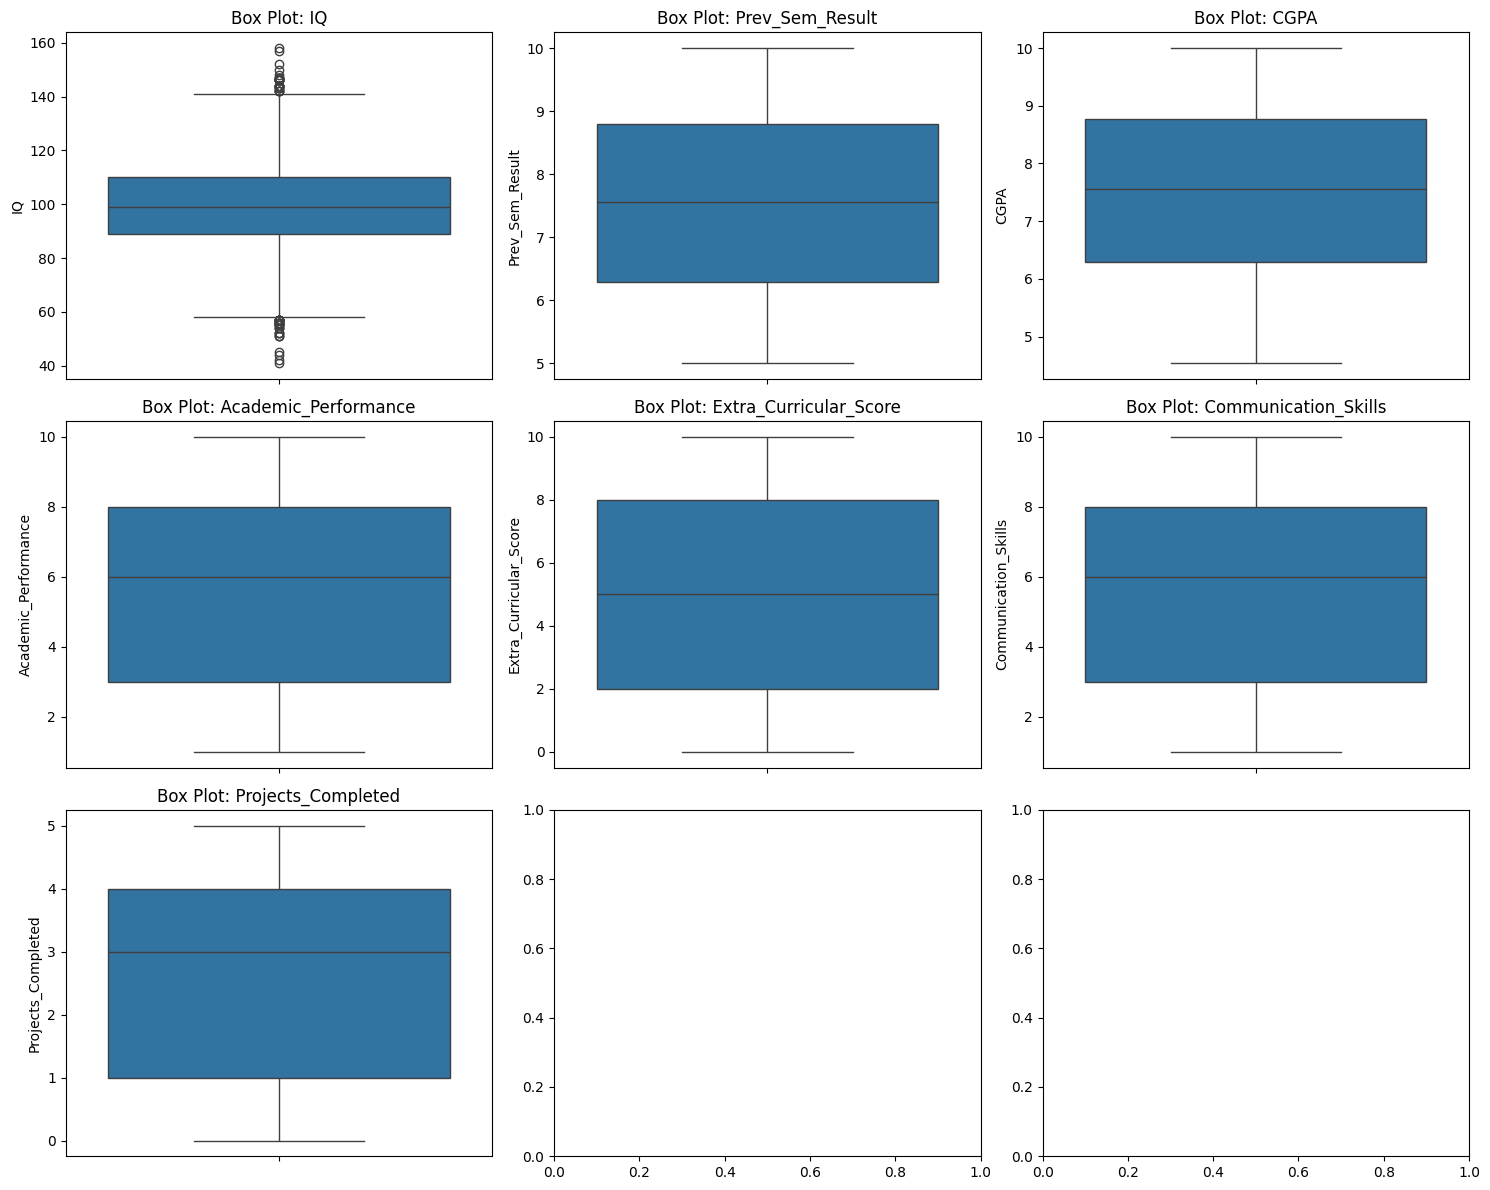

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create box plots for all numerical features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(columns_to_check):
    sns.boxplot(data=df, y=col, ax=axes[idx])
    axes[idx].set_title(f'Box Plot: {col}')

plt.tight_layout()
plt.show()

### SCALING!!!

In [14]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# BEFORE scaling
print("BEFORE SCALING:")
print(df[['IQ', 'CGPA', 'Projects_Completed']].head(10))
print("\nStatistics BEFORE:")
print(df[['IQ', 'CGPA', 'Projects_Completed']].describe())

# Scale the data
features_to_scale = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance',
                     'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']

scaler = StandardScaler()
df_scaled = df.copy()  # Make a copy to compare
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# AFTER scaling
print("\n" + "="*50)
print("AFTER SCALING:")
print(df_scaled[['IQ', 'CGPA', 'Projects_Completed']].head(10))
print("\nStatistics AFTER:")
print(df_scaled[['IQ', 'CGPA', 'Projects_Completed']].describe())

BEFORE SCALING:
    IQ  CGPA  Projects_Completed
0  107  6.28                   4
1   97  5.37                   0
2  109  5.83                   1
3  122  5.75                   1
4   96  7.69                   2
5   96  5.32                   0
6  123  6.58                   2
7  111  8.76                   2
8   92  6.33                   5
9  108  8.60                   1

Statistics BEFORE:
                 IQ          CGPA  Projects_Completed
count  10000.000000  10000.000000        10000.000000
mean      99.471800      7.528296            2.513400
std       15.053101      1.462917            1.715959
min       41.000000      4.540000            0.000000
25%       89.000000      6.290000            1.000000
50%       99.000000      7.550000            3.000000
75%      110.000000      8.770000            4.000000
max      158.000000     10.000000            5.000000

AFTER SCALING:
         IQ      CGPA  Projects_Completed
0  0.500135 -0.853335            0.866381
1 -0.164214 -1.

## ❌ What's Missing (Need to Add!)
### 5. Correlation Analysis

What: Correlation matrix showing relationships between features
Why: Shows which features are related to placement success
How: df.corr() + heatmap visualization
Status: ❌ MISSING - HIGH PRIORITY

### 6. Distribution Visualizations

What: Histograms or box plots for each feature
Why: Shows data spread and shape (normal, skewed, etc.)
How: Histogram plots for all numerical features
Status: ❌ MISSING - HIGH PRIORITY

### 7. Target Variable Analysis

What: Placement rate and class distribution
Why: Shows if data is balanced (currently 16.59% placed)
How: Bar chart or pie chart of Placement_Binary
Status: ❌ MISSING - MEDIUM PRIORITY

### 8. Feature Relationships

What: Scatter plots or pair plots showing feature interactions
Why: Visual exploration of how features relate to placement
How: Scatter plots of key features vs placement
Status: ❌ MISSING - OPTIONAL

# STEP 4: Analysis and Insights

### No plans yet, finish step 3 first

# STEP 5: Presentation Preparation

### Make a streamlit app for the presentation. maybe create a script first out of the data analyzed.

# STEP 6: Presentation Recording

### record a presentation
